In [1]:
# Input: 
path_data = '../../01 data/train_pollution.csv'
target_var = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
split_ratio_train = 0.65
split_ratio_val = 0.15
split_ratio_test = 0.2

In [ ]:
# data source: https://www.kaggle.com/c/tabular-playground-series-jul-2021/data?select=train.csv

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
print(data.shape)
data.head(3)

(7111, 12)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1


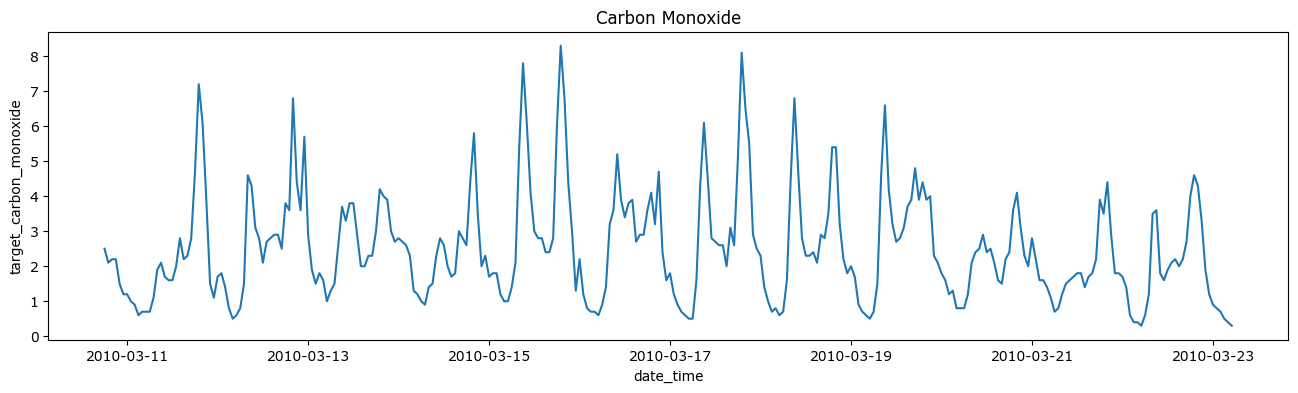

In [40]:
# Visualize
plt.figure(figsize=(16,4))
sns.lineplot(data=data.iloc[:300,:], x='date_time', y='target_carbon_monoxide')
plt.title('Carbon Monoxide')
plt.show()

In [4]:
# Correlation
data.corr()[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

C:\Users\Danamas\AppData\Local\Temp\ipykernel_20908\1474670538.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]


,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
deg_C,-0.007503,0.109757,-0.205984
relative_humidity,0.016589,-0.022895,0.178608
absolute_humidity,-0.013756,0.186293,-0.101911
sensor_1,0.857215,0.842534,0.643044
sensor_2,0.821025,0.964440,0.604795
sensor_3,-0.547567,-0.735545,-0.427622
sensor_4,0.571412,0.783750,0.235662
sensor_5,0.834501,0.877662,0.708270
target_carbon_monoxide,1.000000,0.881884,0.806099
target_benzene,0.881884,1.000000,0.664235


In [5]:
# Select features
# If univariate, select the only target var.
# If parallel, select the target var and features.
data = data[
    ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
]

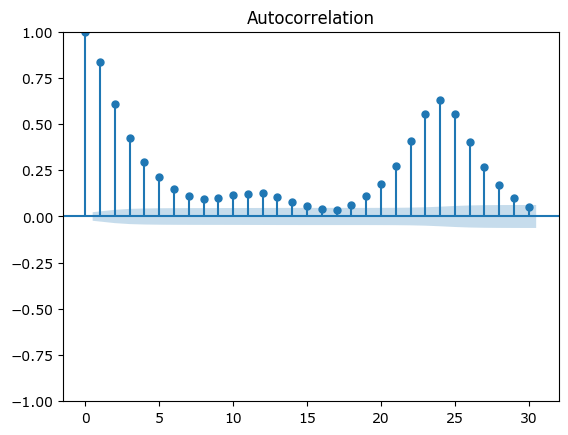

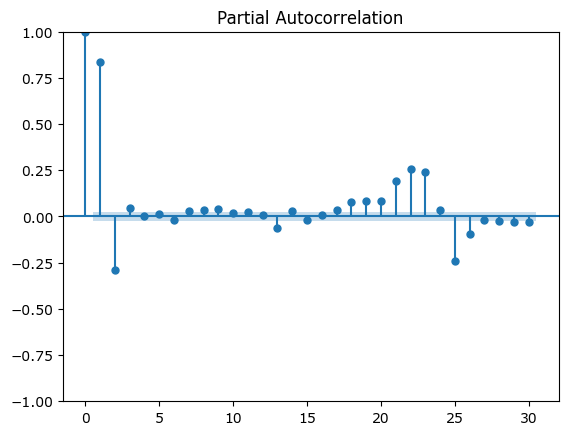

In [8]:
# Autocorrelation
plot_acf(data['target_carbon_monoxide'], lags=30)
plot_pacf(data['target_carbon_monoxide'], lags=30)
# pacf shows that the dependence can be captured using lags 1 until 3
plt.show()

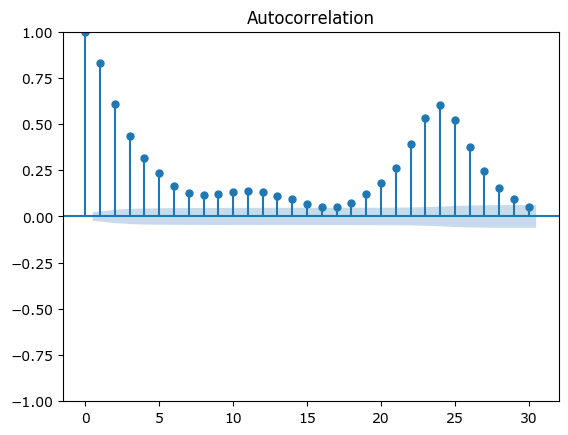

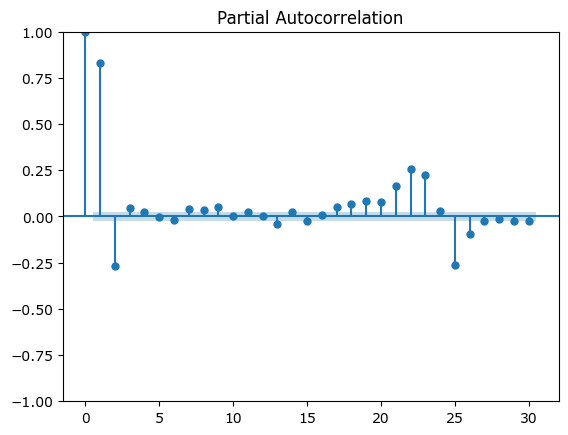

In [6]:
# Autocorrelation
plot_acf(data['target_benzene'], lags=30)
plot_pacf(data['target_benzene'], lags=30)
# pacf shows that the dependence can be captured using lags 1 until 3
plt.show()

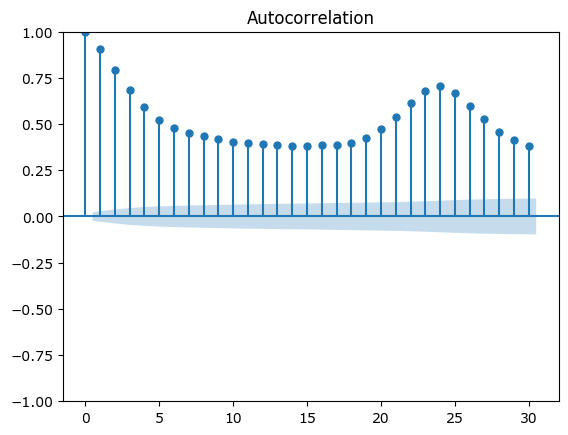

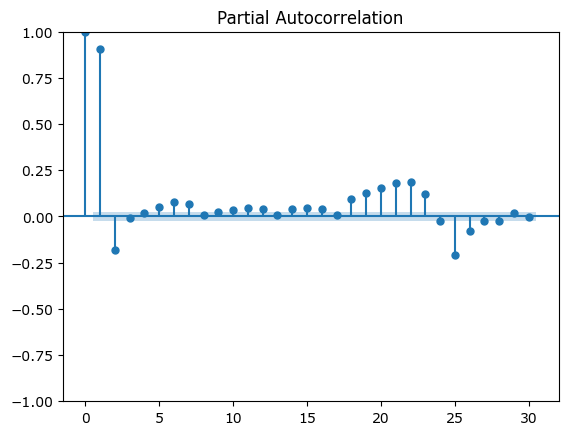

In [7]:
# Autocorrelation
plot_acf(data['target_nitrogen_oxides'], lags=30)
plot_pacf(data['target_nitrogen_oxides'], lags=30)
# pacf shows that the dependence can be captured using lags 1 until 3
plt.show()

In [8]:
# Feature engineering with lag time
def feature_shift_time(data: pd.DataFrame, lag=1, n_out=1, dropnan=True):
    var_names = list(data.columns)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    column, feature = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(lag, 0, -1):
        column.append(df.shift(i))
        feature += [f'{v}(t-{i})' for v in var_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        column.append(df.shift(-i))
        if i == 0:
            feature += [f'{v}(t)' for v in var_names]
        else:
            feature += [f'{v}(t+{i})' for v in var_names]
    # put it all together
    agg = pd.concat(column, axis=1)
    agg.columns = feature
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# Train, val, test split
end_train = int(round(split_ratio_train * len(data), 0))
# end_val is not needed if test split is not made here
end_val = int(round((split_ratio_val + split_ratio_train) * len(data), 0))

In [11]:
# Standard scaler
scaler = StandardScaler()
scaler.fit(data.iloc[:end_train, :])
# Save the scaler
# pickle.dump(scaler, open('../../03 outputs/parallel/01/time_scaler.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

# Load standard scaler
# scaler = pickle.load(open('../../03 outputs/parallel/01/time_scaler.pickle', 'rb'))

In [12]:
### Set the n_lag based on the PACF
n_lag = 3

# Scale
data_prep = data.copy()
data_prep = pd.DataFrame(scaler.transform(data), columns=data_prep.columns)

# Feature engineering with lag time
data_prep = feature_shift_time(data_prep, lag=n_lag, n_out=1)

# Remove features at time t
drop_col = [c for c in data_prep.columns if '(t)' in c and c != target_var]
data_prep = data_prep.drop(columns=[])

print(data_prep.shape)
data_prep.head(3)

(7108, 12)


,target_carbon_monoxide(t-3),target_benzene(t-3),target_nitrogen_oxides(t-3),target_carbon_monoxide(t-2),target_benzene(t-2),target_nitrogen_oxides(t-2),target_carbon_monoxide(t-1),target_benzene(t-1),target_nitrogen_oxides(t-1),target_carbon_monoxide(t),target_benzene(t),target_nitrogen_oxides(t)
3,0.548406,0.371265,0.470854,0.212758,0.057250,-0.297634,0.296670,-0.047421,0.017357,0.296670,0.027344,0.576968
4,0.212758,0.057250,-0.297634,0.296670,-0.047421,0.017357,0.296670,0.027344,0.576968,-0.290715,-0.466107,-0.041843
5,0.296670,-0.047421,0.017357,0.296670,0.027344,0.576968,-0.290715,-0.466107,-0.041843,-0.542452,-0.765169,-0.418268


In [24]:
# Create X and y
X_col = [c for c in data_prep if '(t)' not in c]
y_col = [c for c in data_prep if '(t)' in c]

X_train = data_prep.loc[:end_train, X_col]
X_val = data_prep.loc[end_train+1:end_val, X_col]
X_test = data_prep.loc[end_val+1:, X_col]

y_train = data_prep.loc[:end_train, y_col]
y_val = data_prep.loc[end_train+1:end_val, y_col]
y_test = data_prep.loc[end_val+1:, y_col]

In [25]:
# Save
X_train.to_csv('../../03 outputs/parallel/01/X_train.csv')
y_train.to_csv('../../03 outputs/parallel/01/y_train.csv')
X_val.to_csv('../../03 outputs/parallel/01/X_val.csv')
y_val.to_csv('../../03 outputs/parallel/01/y_val.csv')
X_test.to_csv('../../03 outputs/parallel/01/X_test.csv')
y_test.to_csv('../../03 outputs/parallel/01/y_test.csv')

In [26]:
# Reshape input to be 3D [n of samples, n of lag timesteps, n of features]
n_features = len(data.columns)
X_train = X_train.values.reshape((X_train.shape[0], n_lag, n_features))
X_val = X_val.values.reshape((X_val.shape[0], n_lag, n_features))
X_test = X_test.values.reshape((X_test.shape[0], n_lag, n_features))

y_train = y_train.values.reshape((y_train.shape[0], n_features))
y_val = y_val.values.reshape((y_val.shape[0], n_features))
y_test = y_test.values.reshape((y_test.shape[0], n_features))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(4620, 3, 3) (4620, 3) (1067, 3, 3) (1067, 3) (1421, 3, 3) (1421, 3)


In [27]:
X_train[:3]

array([[[ 0.54840637,  0.3712645 ,  0.47085415],
        [ 0.21275778,  0.05725001, -0.29763354],
        [ 0.29666993, -0.04742149,  0.01735705]],

       [[ 0.21275778,  0.05725001, -0.29763354],
        [ 0.29666993, -0.04742149,  0.01735705],
        [ 0.29666993,  0.02734387,  0.576968  ]],

       [[ 0.29666993, -0.04742149,  0.01735705],
        [ 0.29666993,  0.02734387,  0.576968  ],
        [-0.29071511, -0.46610748, -0.0418433 ]]])

In [28]:
y_train[:3]

array([[ 0.29666993,  0.02734387,  0.576968  ],
       [-0.29071511, -0.46610748, -0.0418433 ],
       [-0.54245155, -0.7651689 , -0.41826823]])

In [29]:
# Save
np.save('../../03 outputs/parallel/01/X_train.npy', X_train)
np.save('../../03 outputs/parallel/01/y_train.npy', y_train)
np.save('../../03 outputs/parallel/01/X_val.npy', X_val)
np.save('../../03 outputs/parallel/01/y_val.npy', y_val)
np.save('../../03 outputs/parallel/01/X_test.npy', X_test)
np.save('../../03 outputs/parallel/01/y_test.npy', y_test)